In [5]:
# @title
import numpy as np, os, matplotlib.pyplot as plt, warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
np.seterr(all="ignore")

{'divide': 'ignore', 'over': 'ignore', 'under': 'ignore', 'invalid': 'ignore'}

In [15]:
# @title
def load_hw07_strict():
    paths = ["/content/hw07-data.npz"]
    for p in paths:
        if os.path.exists(p):
            z = np.load(p, allow_pickle=True)
            ii = z["ii"]; dt = float(z["dt"][()]); y0 = z["y0"].astype(float)
            T = dt*(len(ii)-1)
            def ie(t):
                k = int(t/dt)
                return float(ii[k]) if 0 <= k < len(ii) else 0.0
            return T, dt, y0, ie, p
    raise FileNotFoundError("找不到 'hw07-data.npz'（或 'data/hw07-data.npz'）。請先上傳後再執行。")

T_data, dt_data, y0_data, ie_data, data_path = load_hw07_strict()
print(f"[OK] 已載入：{data_path}  |  T={T_data:.3f} ms, dt={dt_data:.4f} ms, y0={y0_data}")

[OK] 已載入：/content/hw07-data.npz  |  T=1000.000 ms, dt=0.1000 ms, y0=[-6.50e+01  3.18e-01  5.30e-02  5.96e-01]


In [7]:
# @title
E_NA, G_NA = 50.0, 1.2
E_K,  G_K  = -77.0, 0.36
E_L,  G_L  = -54.387, 0.003
C_M = 0.1

def _exp(z): return np.exp(np.clip(z, -100.0, 100.0))
def _vtrap(x):
    x = np.asarray(x, float)
    xc = np.clip(x, -100.0, 100.0); den = -np.expm1(-xc)
    out = np.empty_like(xc); near = np.abs(x) < 1e-6
    out[near]  = 1.0 + 0.5*xc[near]; out[~near] = xc[~near]/den[~near]; return out

def alpha_n(V): V=np.asarray(V,float); return 0.1 * _vtrap(0.1*(V+55.0))
def beta_n(V):  V=np.asarray(V,float); return 0.125 * _exp(-(V+65.0)/80.0)
def alpha_m(V): V=np.asarray(V,float); return _vtrap(0.1*(V+40.0))
def beta_m(V):  V=np.asarray(V,float); return 4.0   * _exp(-(V+65.0)/18.0)
def alpha_h(V): V=np.asarray(V,float); return 0.07  * _exp(-(V+65.0)/20.0)
def beta_h(V):  V=np.asarray(V,float); return 1.0   / (1.0 + _exp(-0.1*(V+35.0)))

def hh_A(t, y, ie):
    V, n, m, h = y
    aV = (G_L*E_L + G_K*(n**4)*E_K + G_NA*(m**3)*h*E_NA + ie(t)) / C_M
    return np.array([aV, alpha_n(V), alpha_m(V), alpha_h(V)], float)

def hh_B(t, y, phi=1.0):
    V, n, m, h = y
    gt = G_L + G_K*(n**4) + G_NA*(m**3)*h
    return np.array([gt / C_M,
                     (alpha_n(V)+beta_n(V))*phi,
                     (alpha_m(V)+beta_m(V))*phi,
                     (alpha_h(V)+beta_h(V))*phi], float)

def hh_yinf(t, y, ie, phi=1.0):
    A = hh_A(t, y, ie); B = np.maximum(hh_B(t, y, phi), 1e-12); return A / B

def hh_tau(t, y, phi=1.0):
    B = np.maximum(hh_B(t, y, phi), 1e-12); return 1.0 / B

def euler_step_ABi(t, y, A, B, dt):
    Bb = np.maximum(B(t, y), 1e-12); Yin = A(t, y) / Bb
    fac = np.exp(-np.clip(Bb*dt, 0.0, 100.0))
    yn = Yin + (y - Yin)*fac; yn[0] = np.clip(yn[0], -120.0, 90.0); yn[1:] = np.clip(yn[1:], 0.0, 1.0)
    return yn

def euler_step_exp(t, y, yinf, tau, dt, ie, phi=1.0):
    Yin = yinf(t, y, ie, phi); Tv  = np.maximum(tau(t, y, phi), 1e-9)
    fac = np.exp(-np.clip(dt / Tv, 0.0, 100.0))
    yn = Yin + (y - Yin)*fac; yn[0] = np.clip(yn[0], -120.0, 90.0); yn[1:] = np.clip(yn[1:], 0.0, 1.0)
    return yn

def simulate(T, dt, y0, stepper, ie, phi=1.0):
    n = int(T/dt)+1; ts = np.linspace(0.0, T, n); ys = np.empty((n,4), float); ys[0] = y0
    for i in range(1, n):
        t = ts[i-1]
        if stepper is euler_step_exp:
            ys[i] = stepper(t, ys[i-1], hh_yinf, hh_tau, dt, ie, phi)
        else:
            ys[i] = stepper(t, ys[i-1], lambda tt,yy: hh_A(tt,yy,ie), lambda tt,yy: hh_B(tt,yy,phi), dt)
    return ts, ys

def count_spikes_window(ts, V, t_on, t_off, thr=-20.0, refractory=1.0):
    m = (ts >= t_on) & (ts <= t_off); T, VV = ts[m], V[m]
    if len(T) < 2: return 0, np.empty(0)
    up = (VV[:-1] < thr) & (VV[1:] >= thr); tcs = T[1:][up]
    if tcs.size == 0: return 0, np.empty(0)
    sp = [tcs[0]]
    for tc in tcs[1:]:
        if tc - sp[-1] >= refractory: sp.append(tc)
    return len(sp), np.array(sp)

## EX1 — `exp` vs `ABi`（同一輸入）

EX1 ΔV: max=1.613e-12 mV, mean=1.033e-13 mV


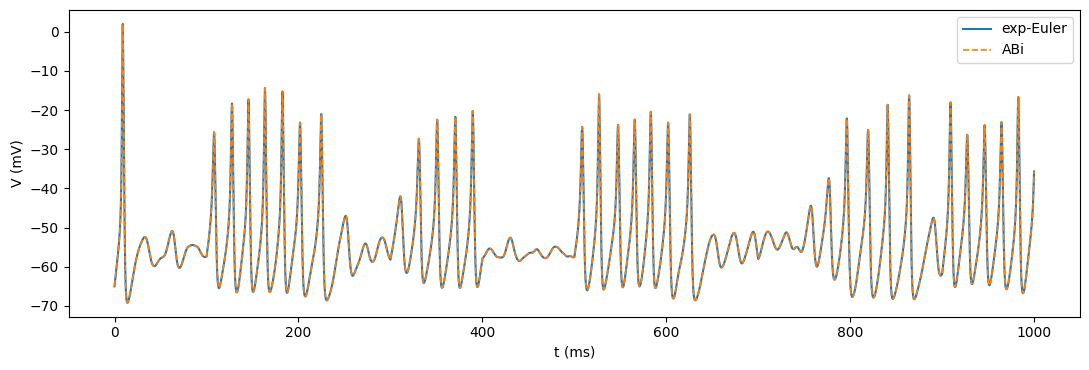

In [8]:
# @title
ts1, ys1 = simulate(T_data, dt_data, y0_data, euler_step_exp, ie_data)
ts2, ys2 = simulate(T_data, dt_data, y0_data, euler_step_ABi, ie_data)
dv = np.abs(ys1[:,0] - ys2[:,0])
print(f"EX1 ΔV: max={dv.max():.3e} mV, mean={dv.mean():.3e} mV")
plt.figure(figsize=(11,3.8))
plt.plot(ts1, ys1[:,0], label="exp-Euler"); plt.plot(ts2, ys2[:,0], "--", label="ABi", lw=1.2)
plt.xlabel("t (ms)"); plt.ylabel("V (mV)"); plt.legend(); plt.tight_layout()
plt.savefig("ex1_overlay.png", dpi=160); plt.show()

## EX2 — 50–150 ms 方波（找 ≥6 spikes）

No ≥6 spikes in 0.005–20 µA/mm² (50–150 ms).


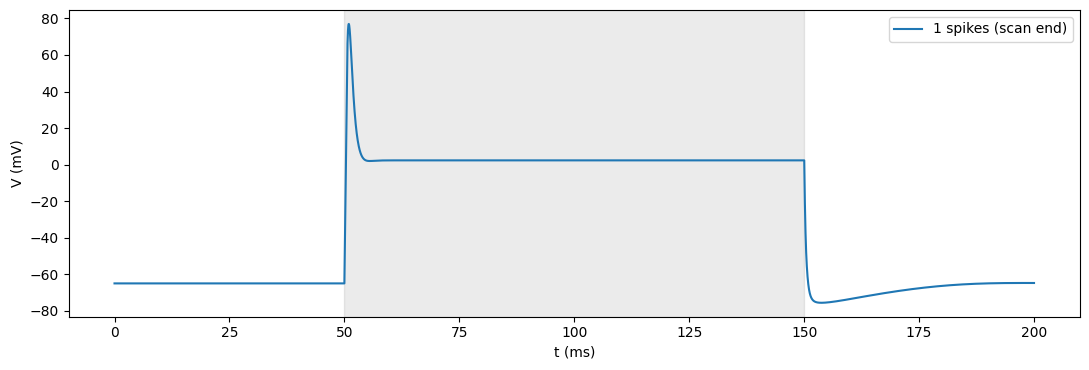

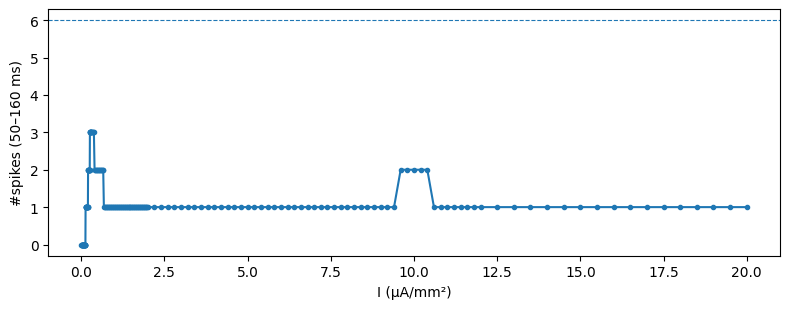

In [9]:
# @title
def pulse(I, t_on=50.0, t_off=150.0):
    return lambda t: (I if (t_on <= t <= t_off) else 0.0)

def scan_fI(I_list, dt=0.02, y0=None, t_on=50.0, t_off=150.0, thr=-20, refr=1.0):
    y0 = y0_data if y0 is None else y0
    ns = []; last_ts=None; last_ys=None
    for I in I_list:
        ie = pulse(I, t_on, t_off)
        ts, ys = simulate(200.0, dt, y0, euler_step_ABi, ie)
        n,_ = count_spikes_window(ts, ys[:,0], t_on, t_off+10.0, thr=thr, refractory=refr)
        ns.append(n); last_ts, last_ys = ts, ys
    return np.array(ns), last_ts, last_ys

coarse = np.concatenate([np.arange(0.005,0.30,0.005),
                         np.arange(0.30, 2.00, 0.02),
                         np.arange(2.0, 12.0, 0.20),
                         np.arange(12.0,20.1,0.50)])
Ns, lts, lys = scan_fI(coarse, dt=0.02)

found = np.where(Ns>=6)[0]
if found.size==0:
    print("No ≥6 spikes in 0.005–20 µA/mm² (50–150 ms).")
    ts, ys = lts, lys
    n,_ = count_spikes_window(ts, ys[:,0], 50, 160, thr=-20, refractory=1.0)
    plt.figure(figsize=(11,3.8)); plt.plot(ts, ys[:,0], label=f'{n} spikes (scan end)')
    plt.axvspan(50,150, alpha=.08, color='k'); plt.xlabel('t (ms)'); plt.ylabel('V (mV)')
    plt.legend(); plt.tight_layout(); plt.savefig("ex2_trace.png", dpi=160); plt.show()
else:
    i0 = found[0]
    lo = coarse[max(0, i0-1)]; hi = coarse[i0]
    bestI = None
    for _ in range(10):
        mid = 0.5*(lo+hi)
        n,_ = scan_fI([mid], dt=0.02); n=int(n[0])
        if n>=6: bestI=mid; hi=mid
        else: lo=mid
    print(f"First I with ≥6 spikes ≈ {bestI:.4f} µA/mm²")
    ts, ys = simulate(200.0, 0.02, y0_data, euler_step_ABi, pulse(bestI))
    k,_ = count_spikes_window(ts, ys[:,0], 50, 160, thr=-20, refractory=1.0)
    plt.figure(figsize=(11,3.8)); plt.plot(ts, ys[:,0], label=f'≥6 spikes @ I≈{bestI:.3f}')
    plt.axvspan(50,150, alpha=.08, color='k'); plt.xlabel('t (ms)'); plt.ylabel('V (mV)')
    plt.legend(); plt.tight_layout(); plt.savefig("ex2_trace.png", dpi=160); plt.show()

plt.figure(figsize=(8,3.2)); plt.plot(coarse, Ns, '.-'); plt.axhline(6, ls='--', lw=0.8)
plt.xlabel('I (µA/mm²)'); plt.ylabel('#spikes (50–160 ms)')
plt.tight_layout(); plt.savefig("ex2_fI.png", dpi=160); plt.show()

## EX3 — Brian2 smoke test（可選）

In [13]:
!pip install brian2

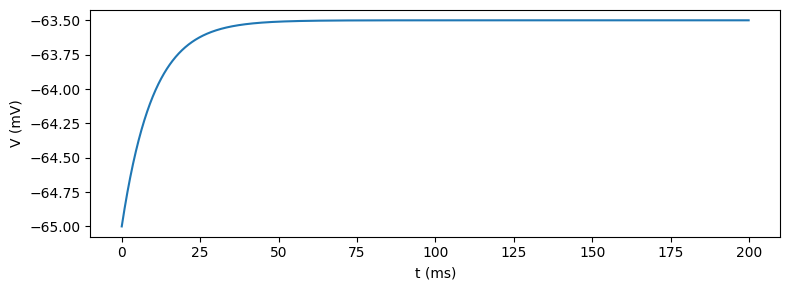

Brian2 ok.


In [14]:
# @title
try:
    import brian2 as b2
    from brian2 import ms, mV, nA, NeuronGroup, StateMonitor, run, defaultclock, start_scope
    start_scope(); defaultclock.dt = 0.1*ms
    tau = 10*ms; EL = -65*mV; VT = -50*mV; VR = -65*mV; R = 0.1*mV/nA
    eq = 'dV/dt = (EL - V + R*I)/tau : volt\nI : amp'
    G = NeuronGroup(1, eq, threshold='V>VT', reset='V=VR', method='euler')
    G.V = VR; G.I = 15*nA
    M = StateMonitor(G, 'V', record=0); run(200*ms)
    plt.figure(figsize=(8,3)); plt.plot(M.t/ms, M.V[0]/mV)
    plt.xlabel('t (ms)'); plt.ylabel('V (mV)'); plt.tight_layout()
    plt.savefig("ex3_brian2.png", dpi=160); plt.show()
    print("Brian2 ok.")
except Exception as e:
    print("Brian2 not installed or failed:", e)